In [1]:

import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque

from scipy.ndimage.measurements import label
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.transform import resize


# Show plots inline notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
cars = glob.glob("./dataset/vehicles/**/*.png", recursive=True)
non_cars = glob.glob("./dataset/non-vehicles/**/*.png", recursive=True)

# Read X Vector
X = []
for file in cars:    
    X.append(mpimg.imread(file))
for file in non_cars:    
    X.append(mpimg.imread(file))
X = np.array(X)

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

# Split train and validation dataset with 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=63)

# Show messages
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


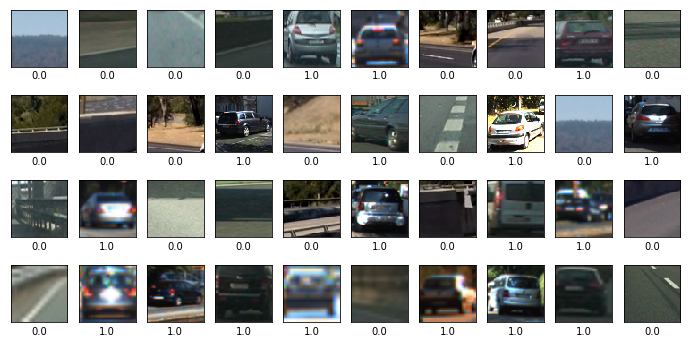

In [3]:
def showRandomImages():
    fig = plt.figure(figsize=(12, 6))
    for i in range(0, 40):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4,10,i+1)
        axis.set_xlabel(Y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(X_train[number])
    plt.show()

showRandomImages()

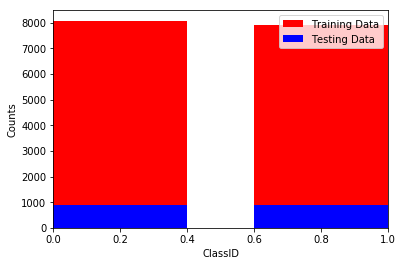

In [5]:
def showDistribution():
    _, training_counts = np.unique(Y_train, return_counts = True)
    _, test_counts = np.unique(Y_test, return_counts = True)
    plt.bar( np.arange( 2 ), training_counts,   color='r', label='Training Data')
    plt.bar( np.arange( 2 ), test_counts,  color='b', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([0, 1])
    plt.legend()
    plt.show()
    
showDistribution()

In [8]:
def create_model(input_shape=(64,64,3)):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv1',input_shape=input_shape, padding="same"))  
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2',padding="same"))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv3',padding="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (8,8), activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    model.add(Conv2D(1, (1,1), name="dense2", activation="tanh")) 
    
    return model

model = create_model()
model.summary()
model.add(Flatten())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 128)       3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
__________

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
62s - loss: 0.5140 - acc: 0.4919 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 2/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 3/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 4/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 5/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 6/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 7/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 8/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 9/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 10/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 11/20
25s - loss: 0.5054 - acc: 0.4946 - val_loss: 0.5011 - val_acc: 0.4989
Epoch 12/20
24s - loss: 0.5054 - acc: 0.4946 - val_loss: 0

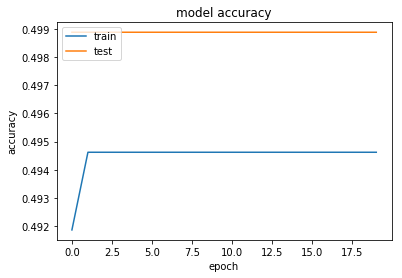

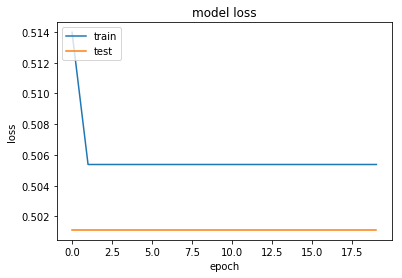

In [9]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=2, validation_data=(X_test, Y_test))

plot_results(history)

model.save_weights('./dataset/model_1.h5')

In [10]:

# Load the fine-tuned for the final network
model.load_weights('./dataset/model_1.h5')
print("Weights loaded!")

Weights loaded!


NN Prediction: CAR with value 1.0
Ground-truth: CAR with value 1.0


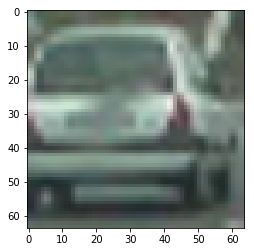

In [12]:

# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))
    
# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

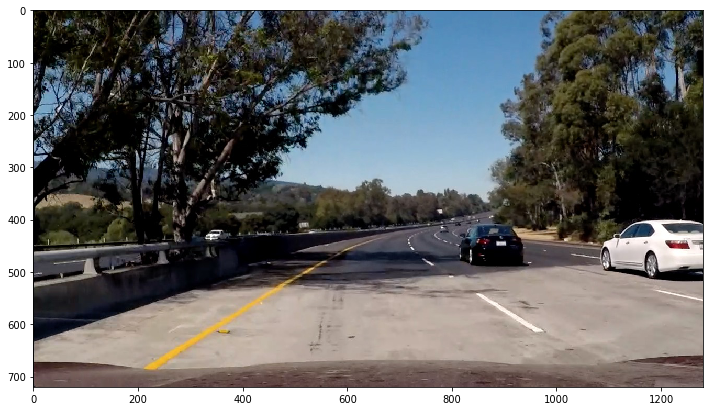

In [13]:
# Load a specific sample image
img = mpimg.imread('./test_images/test5.jpg')

# Display it
fig = plt.figure(figsize=(12,20))
plt.imshow(img)

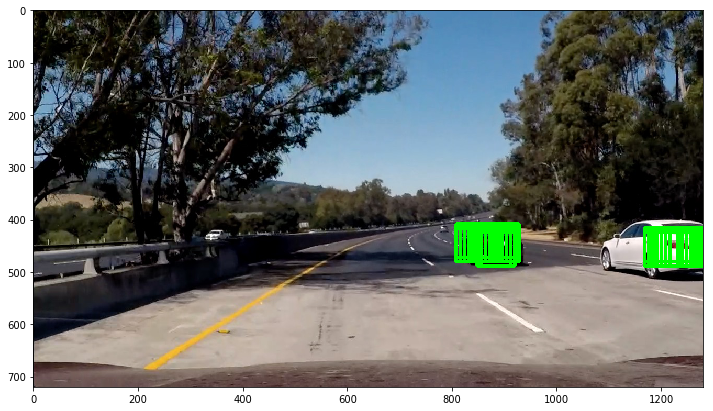

In [14]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_cars(img):
    # We crop the image to 440-660px in the vertical direction
    cropped = img[400:660, 0:1280]
    heat = heatmodel.predict(cropped.reshape(1,cropped.shape[0],cropped.shape[1],cropped.shape[2]))
    # This finds us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>0.9999999])
    y = (yy[heat[0,:,:,0]>0.9999999])
    hot_windows = []
    # We save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8,400 + j*8), (i*8+64,400 +j*8+64)))
    return hot_windows

# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((260, 1280, 3))
# Load the weights
heatmodel.load_weights('./dataset/model.h5')

# Search for our windows
hot_windows = search_cars(img)

# Draw the found boxes on the test image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)                    

# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)

2 cars found


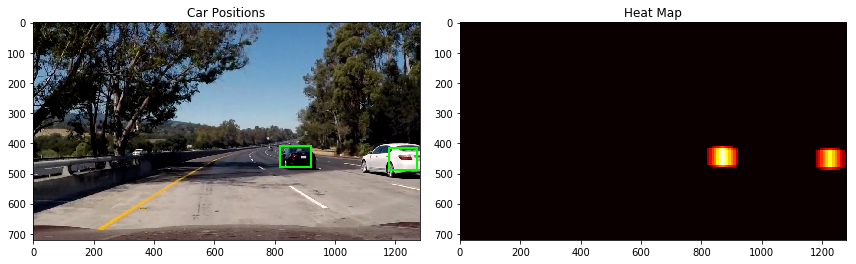

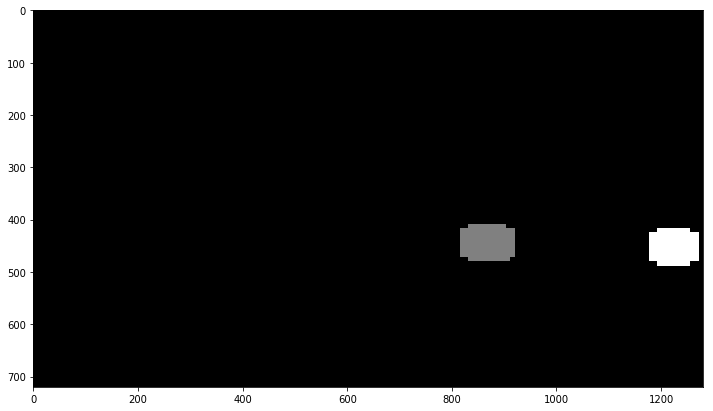

In [15]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Create image for the heat similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
boxes = label(heatmap)

# Create the final image
draw_img = draw_labeled_bboxes(np.copy(img), boxes)

# Show the car positions and the heat map with threshold applied
fig = plt.figure(figsize=(12,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Print information about the cars found
print(boxes[1], 'cars found')
fig = plt.figure(figsize=(12,20))
plt.imshow(boxes[0], cmap='gray')

In [16]:
def process_image(img):      
    # Find the lane lines first
#     img_lanes = findLanes(img)
    
    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Search for cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)

    # Create the final image
    draw_img = draw_labeled_bboxes(img, boxes)
    
    # Return it to the video processing tool
    return draw_img

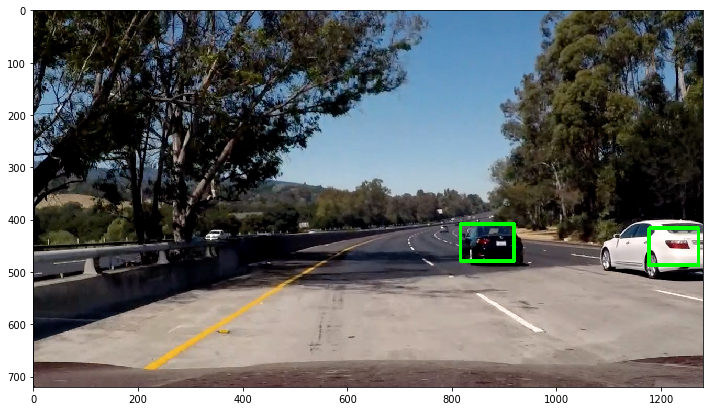

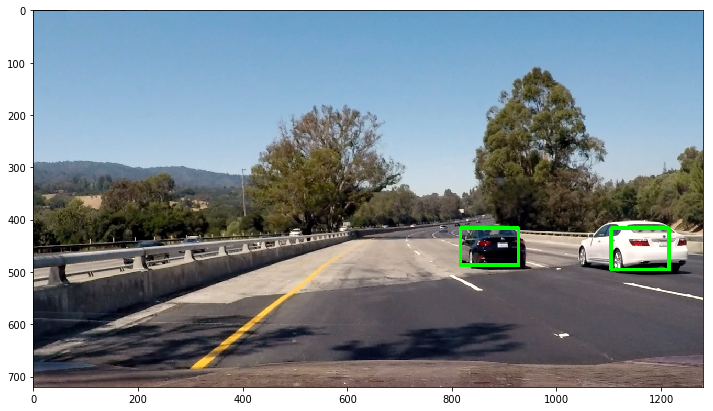

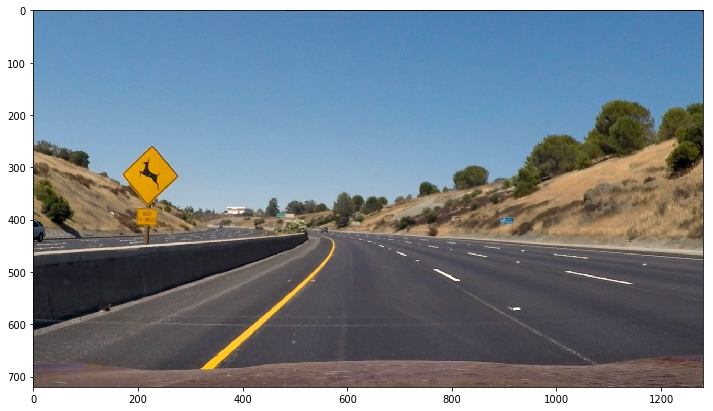

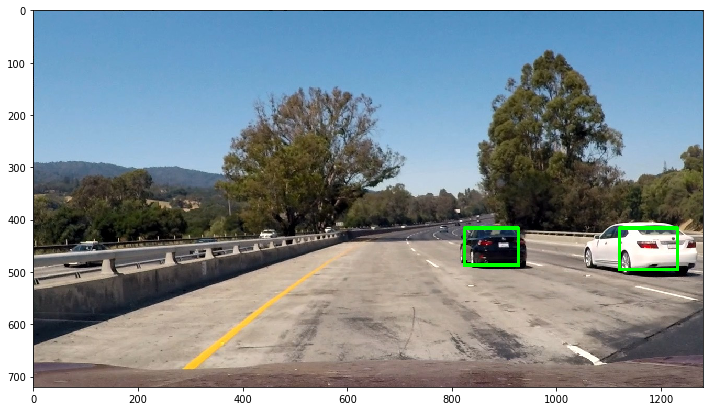

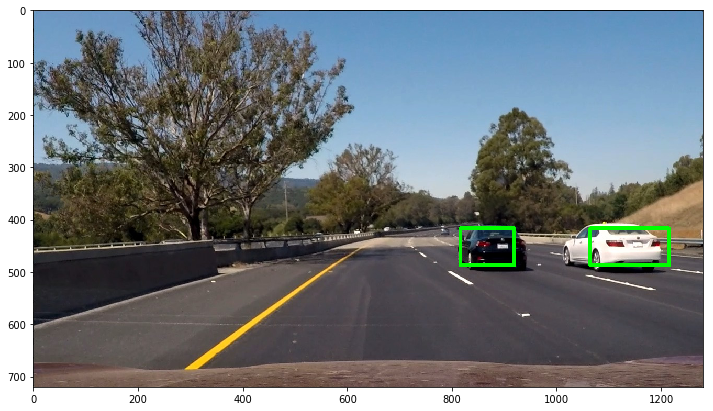

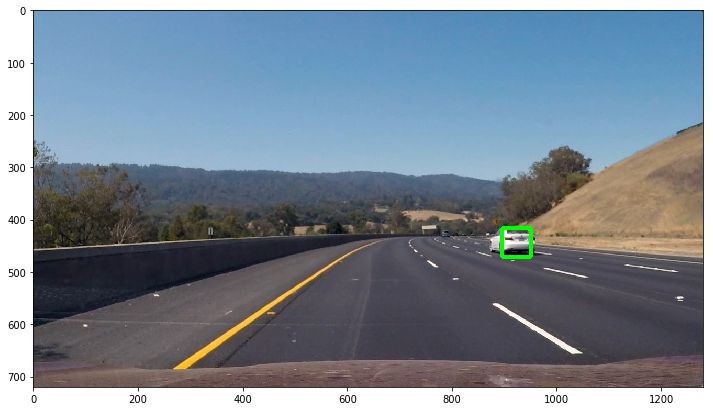

In [17]:
# Repeat for all images
for index, image in enumerate(os.listdir("test_images/")):
    # Restore averages for every image
    prev_frames = []
    prev_curvatures = []
    prev_car_off = []
    
    # Read in image
    img = skimage.io.imread('test_images/' + image)
    
    # Let the image go through the pipeline
    img_lane = process_image(img)
    
    #Display the final image
    fig = plt.figure(figsize=(12,20))
    plt.imshow(img_lane)
    
    #Save it to file
    fig.savefig('output_images/' + image, bbox_inches='tight', pad_inches=0)


In [18]:
# Create history element
history = None

# Our video processing pipeline
def process_video(img):
    # Find the lane lines first
#     img_lanes = findLanes(img)
    
    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Find the cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, boxes[1]+1):
        # Find pixels with each car_number label value
        nonzero = (boxes[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Append current boxe to history
        history.append([np.min(nonzerox),np.min(nonzeroy),np.max(nonzerox),np.max(nonzeroy)])
    
    # Get recent boxes for the last 30 fps
    recent_boxes = np.array(history).tolist()

    # Groups the object candidate rectangles with difference of 10%
    boxes = cv2.groupRectangles(recent_boxes, 10, .1)
    
    # Draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(img, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
            
    # Return image with found cars and lanes
    return img

In [19]:
# Restore averages
prev_frames = []
prev_curvatures = []
prev_car_off = []
# Create history for 30 frames
history = deque(maxlen=30)
# Process the video
clip_output = 'result_1.mp4'
clip = VideoFileClip("project_video.mp4")
clip_process = clip.fl_image(process_video)
%time clip_process.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video result_1.mp4
[MoviePy] Writing video result_1.mp4


100%|█████████▉| 1260/1261 [00:51<00:00, 24.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_1.mp4 

CPU times: user 42.6 s, sys: 10.2 s, total: 52.8 s
Wall time: 51.5 s


### References
1. https://github.com/tatsuyah/vehicle-detection
2. https://github.com/maxritter/SDC-Vehicle-Lane-Detection